The purpose of this notebook is to demonstrate analysis conducted on cleaned and normalized data. We will seek to supplement the data found in existing report. Additionally, we will take a brief look at additional analytics that may strengthen analysis/provide impact metrics. 

We will also utilize custom styling methods in hopes of creating a uniform analytical branding style.

For demonstration purposes only.

In [3]:
# Messy imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from wordcloud import WordCloud
from tqdm import tqdm
import re
import os
import sys
import plotly.express as px
import plotly.graph_objects as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
sys.path.append(os.path.join('..', 'utilities'))  # Navigate to utilities folder
from vis_style import apply_plotly_style, apply_matplotlib_style, BMHC_COLORS

In [5]:
# .Env variables and DB Connection
load_dotenv()

user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

conn_str = f'mssql+pymssql://{user}:{password}@{host}:{port}/{db}' 

engine = create_engine(conn_str)

- All analysis will be conducted primarily on the client satisfaction dataset. Will not require data transformation. Our analysis will be query based and then visualized via python library (plotly for interactive, matplotlib for static)

In [4]:
# Create dataset for visual
query = """
SELECT 
    YEAR(timestamp) as year,
    MONTH(timestamp) as month,
    COUNT(*) as responses
FROM client_satisfaction
GROUP BY YEAR(timestamp), MONTH(timestamp)
ORDER BY year, month
"""

df = pd.read_sql(query, engine)

df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Basic interactive bar chart
fig = px.bar(df, 
             x='date', 
             y='responses',
             title='Survey Response by Month',
             labels={'date': 'Month', 'responses': 'Number of Responses'},
             hover_data={'year': True, 'month': True})

# Add mean line
fig.add_hline(y=df['responses'].mean(), 
              line_dash="dash", 
              line_color=BMHC_COLORS['gold'],
              annotation_text=f"2025 Average: {df['responses'].mean():.1f}")

# Customize layout
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Responses',
    hovermode='x unified',
    height=600,
    showlegend=True
)

# Add text on bars
fig.update_traces(texttemplate='%{y}', textposition='outside')
apply_plotly_style(fig)
fig.show()


cohort-based time series analysis on healthcare visit data using SQL.

Aggregating client visit records by year and month.
Calculating the average number of days between doctor visits for each cohort (month/year).
Preparing metrics to monitor client engagement, visit frequency, and access to care over time.

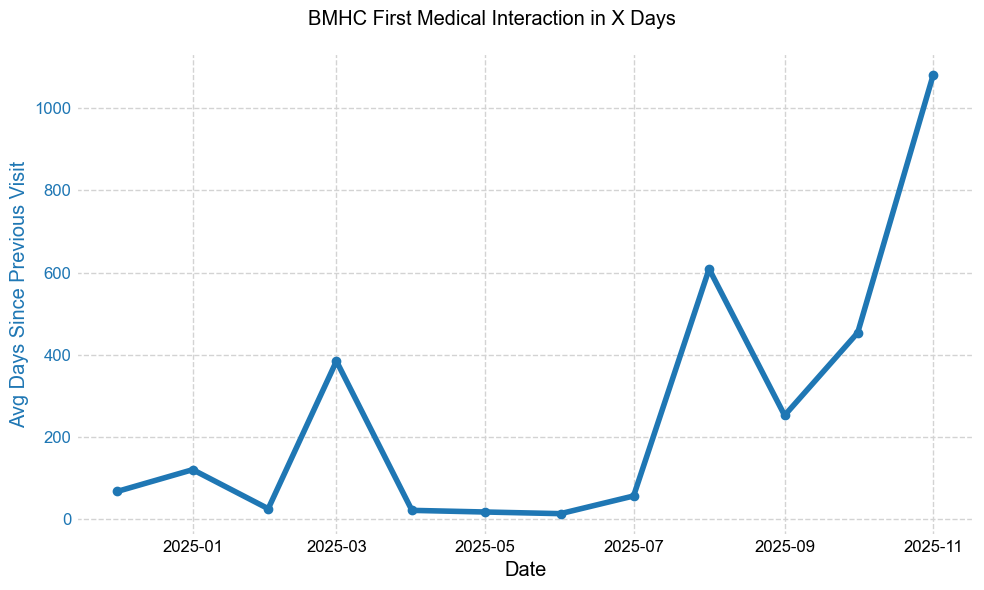

In [5]:
# Create dataset for visual
query = """
WITH total_records AS (
    SELECT COUNT(*) AS total FROM client_satisfaction
),
monthly_counts AS (
    SELECT
        YEAR([timestamp]) AS year,
        MONTH([timestamp]) AS month,
        COUNT(*) AS month_count,
        AVG(DATEDIFF(day, date_previous_doctor_visit, [timestamp])) AS avg_days_since_prev
    FROM client_satisfaction
    GROUP BY YEAR([timestamp]), MONTH([timestamp])
)
SELECT
    m.year,
    m.month,
    m.month_count,
    t.total,
    CAST(m.month_count AS FLOAT) / t.total AS per_capita,
    m.avg_days_since_prev AS "Average span in days since previous doctor visit"
FROM monthly_counts m
CROSS JOIN total_records t
ORDER BY m.year, m.month
"""

df = pd.read_sql(query, engine)

# Date column
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# Matplotlib plotting
apply_matplotlib_style()
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(df['date'], df['Average span in days since previous doctor visit'], color='tab:blue', marker='o', label='Avg Days Since Previous Visit')
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Days Since Previous Visit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')


fig.suptitle('BMHC First Medical Interaction in X Days')
fig.tight_layout()
plt.show()


- Difficult to gain any meaninfgul insights from review narrative data due to responses generally being short, noisey, phrases that provide little context.

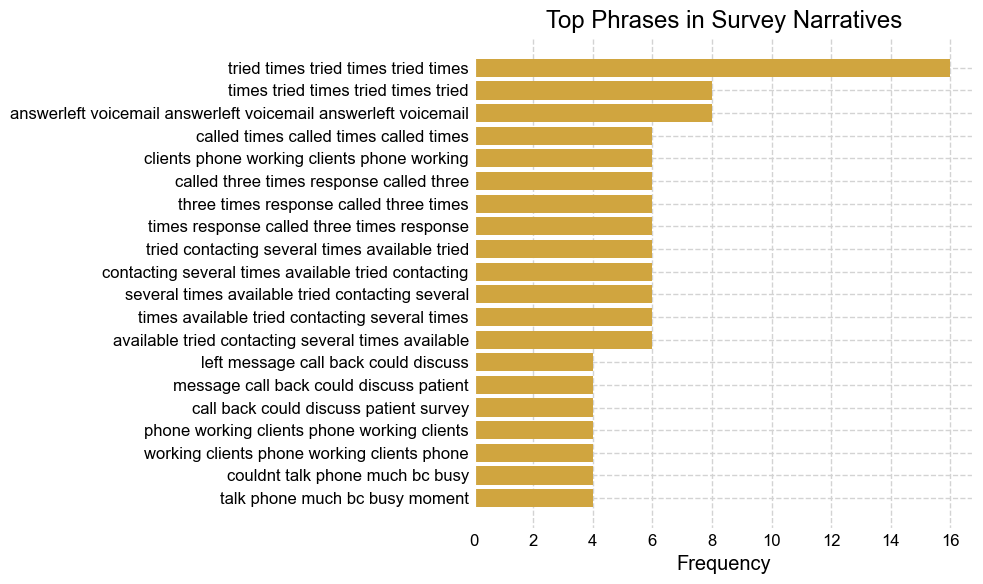

In [6]:
# Create dataset for visual
query = """
SELECT
  health_self_assessment,
  self_health_assessment_narrative + ' ' +
  stress_self_assessment_narrative + ' ' +
  mental_self_assessment_narrative + ' ' +
  physical_self_assessment_narrative AS patient_narrative
FROM client_satisfaction
WHERE self_health_assessment_narrative IS NOT NULL
"""

df = pd.read_sql(query, engine)

# Preprocessing for NLP
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

narCols = [
    'patient_narrative'
]
for col in narCols:
    df[col] = df[col].fillna('').apply(preprocess)

# Stop words
std_stop = set(stopwords.words('english'))
dmn_stop = set(['client','time', 'health', 'get', 'ok', 'answer'])
all_stop = std_stop | dmn_stop

n = 6

phrases = []
for col in narCols:
    for response in df[col]:
        filtered = [word for word in response if word not in all_stop]
        phrases.extend([' '.join(gram) for gram in ngrams(filtered, n)])

phrase_freq = Counter(phrases)
common_phrases = phrase_freq.most_common(20)
#print(common_phrases)
outlier_phrases = [phrase for phrase, count in phrase_freq.items() if count < 4]  # or count <= 2

#print("Outlier phrases:", outlier_phrases)
# Vis
phrases, counts = zip(*common_phrases)
apply_matplotlib_style()
plt.figure(figsize=(10, 6))
plt.barh(phrases, counts, color=BMHC_COLORS['gold'])
plt.xlabel('Frequency')
plt.title('Top Phrases in Survey Narratives')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


In [7]:
# KMeans test
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
import nltk

# lemmatization
#nltk.download('wordnet')
#nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    if isinstance(text, str):
        tokens = text.split()
    else:
        tokens = text  # already a list
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    filtered = [token for token in lemmatized if token not in all_stop]
    return filtered

for col in narCols:
    df[col] = df[col].fillna('').apply(preprocess)

all_responses = []
for col in tqdm(narCols, desc="processing columns"):
    all_responses.extend([' '.join(tokens) for tokens in df[col]])

vectorizer = TfidfVectorizer(max_features=500)
x = vectorizer.fit_transform(all_responses)

k = 5
kmeans = KMeans(n_clusters=k, random_state=25)
labels = kmeans.fit_predict(x)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in tqdm(range(k), desc="Clusters"):
        print(f"Cluster {i}: ", [terms[ind] for ind in order_centroids[i, :10]])

Clusters: 100%|██████████| 5/5 [00:00<00:00, 41692.88it/s]

Cluster 0:  ['seen', 'doctor', 'problem', 'better', 'feeling', 'free', 'gallbladder', 'full', 'friendly', 'friend']
Cluster 1:  ['mentally', 'shape', 'stable', 'complaint', 'stress', 'good', 'zero', 'foot', 'friendly', 'friend']
Cluster 2:  ['mental', 'feeling', 'good', 'well', 'fine', 'stress', 'nothing', 'none', 'complaint', 'right']
Cluster 3:  ['tried', 'wa', 'available', 'better', 'called', 'working', 'getting', 'phone', 'response', 'feel']
Cluster 4:  ['aching', 'trigger', 'excellent', 'stable', 'stress', 'feeling', 'focusing', 'focused', 'follow', 'gave']


As a demonstration of cross-dataset analysis we will conduct multivariate regression in order to investigate any relationships between clockify reporting (group and billable amount) and count of reviews received daily.

{'billable_amount': np.float64(0.01626267165555854), 'group_Administration': np.float64(-3.3430785271688803), 'group_Communications': np.float64(39.84829910228998), 'group_Coordination & Navigation': np.float64(-9.82434758671747), 'group_Information Technology': np.float64(-0.2689506327042174), 'group_Marketing': np.float64(-0.015795033744730236), 'group_Outreach & Engagement': np.float64(7.325270393425692), 'group_Permanent Supportive Housing': np.float64(-13.836994129655501), 'group_SOAR': np.float64(-19.884403585724872)}


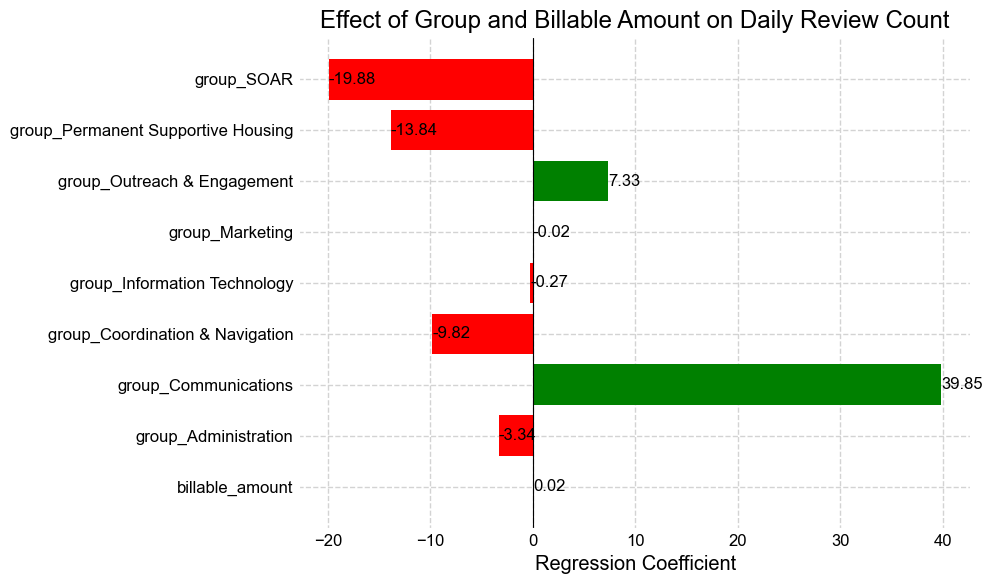

In [8]:
from sklearn.linear_model import LinearRegression

# Create dataset for analysis
query = """
select 
CAST(cm.start_datetime AS date) as date,
cm."group",
SUM(cm.billable_amount_usd) as billable_amount,
COUNT(cs.response_id) as daily_review_count
FROM
clockify_main as cm
JOIN
client_satisfaction as cs
ON
CAST(cs.[timestamp] AS date) = CAST(cm.start_datetime AS date)
GROUP BY
cm."group",
CAST(cm.start_datetime AS date) 
"""

df = pd.read_sql(query, engine)
df.head()

df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, prefix=['group'])
X = df[['billable_amount'] + [col for col in df.columns if col.startswith('group_')]]
y = df['daily_review_count']

model = LinearRegression().fit(X, y)
#print(model.coef_, model.intercept_)
print(dict(zip(X.columns, model.coef_)))

coef_dict = dict(zip(X.columns, model.coef_))

labels = list(coef_dict.keys())
values = list(coef_dict.values())

plt.figure(figsize=(10, 6))
apply_matplotlib_style()
bars = plt.barh(labels, values, color=['green' if v > 0 else 'red' for v in values])
plt.xlabel('Regression Coefficient')
plt.title('Effect of Group and Billable Amount on Daily Review Count')
plt.axvline(0, color='black', linewidth=0.8)
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')
plt.tight_layout()
plt.show()

In [10]:
import plotly.graph_objects as go
# Create dataset for analysis
query = """
SELECT
CAST(AVG(health_self_assessment * 1.0) AS DECIMAL(10,2)) as health_assessment,
CAST(AVG(stress_self_assessment * 1.0) AS DECIMAL(10,2)) as stress_self_assessment,
CAST(AVG(mental_self_assessment * 1.0) AS DECIMAL(10,2)) as mental_assessment,
CAST(AVG(physical_self_assessment * 1.0) AS DECIMAL(10,2)) as physical_assessment
FROM client_satisfaction
"""

df = pd.read_sql(query, engine)

rating = df['health_assessment'].iloc[0]
if rating < 2.5:
    bar_color = "red"
elif rating < 3.5:
    bar_color = "yellow"
else:
    bar_color = "green"

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value= rating,
    domain = {'x': [0, 1], 'y': [0,1]},
    title = {'text': "Health Assessment"},
    gauge = {
        'axis': {'range': [1, 5]},
        'bar': {'color': bar_color},
        'bgcolor': 'white'
    }
))

apply_plotly_style(fig)
fig.show()


In [16]:
from plotly.subplots import make_subplots
# Create dataset for analysis
query = """
SELECT
    SUM(CASE WHEN medical_needs_met = 1 THEN 1 ELSE 0 END) AS medical_needs_met_true,
    SUM(CASE WHEN medical_needs_met = 0 THEN 1 ELSE 0 END) AS medical_needs_met_false,
    SUM(CASE WHEN provider_expectations = 1 THEN 1 ELSE 0 END) AS provider_expectations_true,
    SUM(CASE WHEN provider_expectations = 0 THEN 1 ELSE 0 END) AS provider_expectations_false,
    SUM(CASE WHEN clinical_trial_interest = 1 THEN 1 ELSE 0 END) AS trial_interest_true,
    SUM(CASE WHEN clinical_trial_interest = 0 THEN 1 ELSE 0 END) AS trial_interest_false,
    SUM(CASE WHEN survey_interest = 1 THEN 1 ELSE 0 END) AS survey_interest_true,
    SUM(CASE WHEN survey_interest = 0 THEN 1 ELSE 0 END) AS survey_interest_false
FROM client_satisfaction
"""

df = pd.read_sql(query, engine)

metrics1 = ['Medical Needs Met', 'Provider Expectations']
metrics2 = ['Trial Interest', 'Survey Interest']

true_counts = [
    df['medical_needs_met_true'][0],
    df['provider_expectations_true'][0],
    df['trial_interest_true'][0],
    df['survey_interest_true'][0]
]
false_counts = [
    df['medical_needs_met_false'][0],
    df['provider_expectations_false'][0],
    df['trial_interest_false'][0],
    df['survey_interest_false'][0]
]
#fig = make_subplots(rows=2,cols=2,subplot_titles=metrics)
# fig.add_trace(go.Bar(name='True', x=['True', 'False'], y=[true_counts[0], false_counts[0]], marker_color='green'), row=1, col=1)
# fig.add_trace(go.Bar(name='True', x=['True', 'False'], y=[true_counts[1], false_counts[1]], marker_color='green'), row=1, col=2)
# fig.add_trace(go.Bar(name='True', x=['True', 'False'], y=[true_counts[2], false_counts[2]], marker_color='green'), row=2, col=1)
# fig.add_trace(go.Bar(name='True', x=['True', 'False'], y=[true_counts[3], false_counts[3]], marker_color='green'), row=2, col=2)
# fig.update_layout(title_text="Boolean Metric Counts (2x2 Grid)", showlegend=False)
# fig.show()


# fig = go.Figure(data=[
#     go.Bar(name='True', x=metrics1, y=true_counts, marker_color='green'),
#     go.Bar(name='False', x=metrics1, y=false_counts, marker_color='red')
# ])
# fig.update_layout(barmode='stack', title='Boolean Metric Counts')
# fig.show()

for i, metric in enumerate(metrics1):
    fig = go.Figure(data=[
        go.Pie(
            labels=['True', 'False'],
            values=[true_counts[i], false_counts[i]],
            marker=dict(colors=['green', 'red'])
        )
    ])
    fig.update_layout(title=f"{metric} (True vs False)")
    fig.show()

In [17]:
# Create dataset for analysis
query = """
 SELECT
        COUNT(*)
        FROM
        client_satisfaction
"""

df = pd.read_sql(query, engine)